# Clustering tutorial notebook


This notebook performs clustering of the 4D-STEM dataset of the Au nanocrystal growth experiment in a liquid cell. The data has been prefiltered for the purpose of the tutorial. Our goal is to perform clustering, as described in: 

XXXXX (paper)


Experimental data was collected by Serin Lee (serinl@stanford.edu) and Andrew Barnum (ajbarnum@stanford.edu)

This tutorial was created by: 
- Serin lee (serinl@stanford.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Arthur McCray (amccray@stanford.edu)
- Colin Ophus (cophus@stanford.edu)

# Example Dataset (Zenodo)

This tutorial uses a publicly available 4D-STEM dataset archived on Zenodo.

**Dataset DOI:**  
[10.5281/zenodo.18158817](https://doi.org/10.5281/zenodo.18158817)

**Title:**  
*4D-STEM dataset of Au nanoparticle in liquid cell TEM*

**Description:**  
This dataset contains the raw and prefiltered 4D-STEM data used to demonstrate
the clustering workflow. It is intended for use with this tutorial notebook and the associated publication.

You can download the dataset automatically through the notebook (see code cell below),
or manually via the DOI link.

**How to cite this dataset:**  
If you use the data, please cite:

> S. Lee, C. Ophus “4D-STEM dataset of Au nanoparticle in liquid cell TEM”  
> Zenodo (2025). https://doi.org/10.5281/zenodo.18158817


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM as p4
import pymatgen
from scipy.ndimage import binary_erosion
from py4DSTEM.process.utils import tqdmnd
from scipy.ndimage import gaussian_filter
from py4DSTEM.process.utils.cluster import Cluster
from datetime import datetime
from pathlib import Path 
from cupyx.scipy.ndimage import gaussian_filter as cu_gaussian_filter
import h5py
from tqdm import tqdm
from skimage.filters import threshold_triangle
import scipy.ndimage as ndi 
from skimage.morphology import remove_small_objects, remove_small_holes


cupyx.jit.rawkernel is experimental. The interface can change in the future.


In [3]:
print(np.__version__)
print(p4.__version__)

2.2.6
0.14.19



# Data Download

The following cell will automatically download the prefiltered and compressed npz. data into a local `data/` folder
if it is not already present. The prefiltering workflow is explained in a separate tutorial notebook.



In [5]:
import requests

data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

zenodo_record_id = "18158817"   # replace with Zenodo record ID
file_name = "Prefiltered_4DSTEM_Au_nanoparticle_liquid_cell_TEM.npz"   # replace with your filename

url = f"https://zenodo.org/records/{zenodo_record_id}/files/{file_name}?download=1"
out_path = data_dir / file_name

if not out_path.exists():
    print(f"Downloading {file_name} from Zenodo...")
    r = requests.get(url)
    r.raise_for_status()
    out_path.write_bytes(r.content)
    print("Download complete.")
else:
    print(f"Using existing file: {out_path}")

Download complete.


In [6]:
loaded = np.load(out_path)
dataset = loaded["data"]

# Creating Datacube from prefiltered data

In [7]:
semiangle_convergence_mrad = 0.622
energy = 300e3

In [8]:
dataset = p4.DataCube(
    data=dataset
)

In [9]:
dataset.get_dp_mean()

VirtualDiffraction( A 2-dimensional array of shape (192, 192) called 'dp_mean',
                    with dimensions:

                        dim0 = [0,1,2,...] pixels
                        dim1 = [0,1,2,...] pixels
)

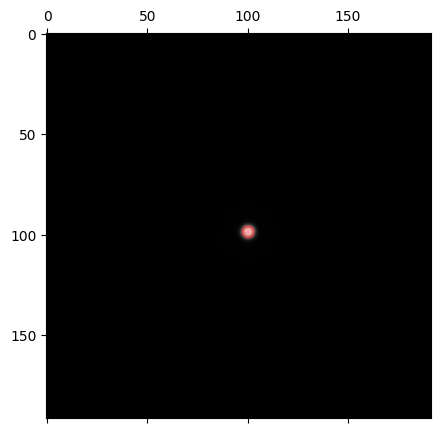

In [10]:
probe_semiangle_px, probe_qx0, probe_qy0  = dataset.get_probe_size(
    plot = True
    
)

In [11]:
dataset.calibration.set_Q_pixel_size(semiangle_convergence_mrad/probe_semiangle_px)
dataset.calibration.set_Q_pixel_units('mrad')

# Virtual ADF

In [12]:
adf_radii = [20,120]

100%|██████████| 262144/262144 [00:04<00:00, 57773.31it/s]


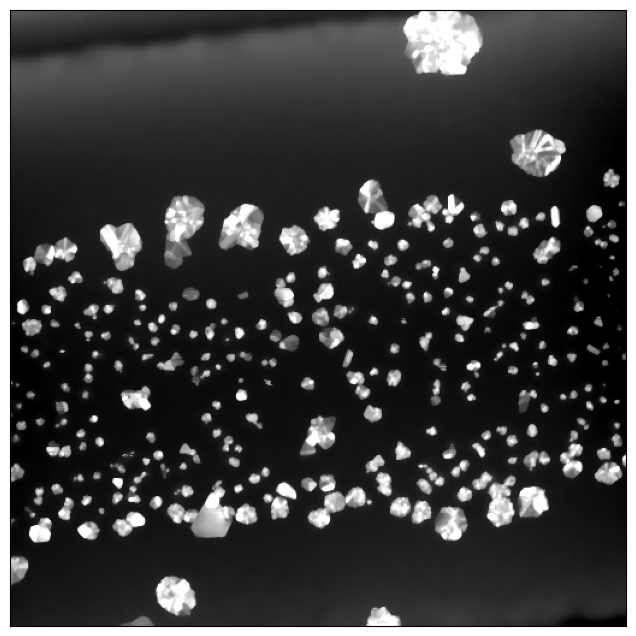

In [13]:
dataset.get_virtual_image(
    mode = 'annulus',
    geometry = ((0,0),(adf_radii[0],adf_radii[1])),
    #geometry = ((0,0),(20,120)),
    name = 'dark_field',
    centered = True
)

fig_df,ax_df = p4.show(
    dataset.tree('dark_field'),
    returnfig = True,
    scalebar = False,
    ticks = False,
    figsize=(8,8)
)


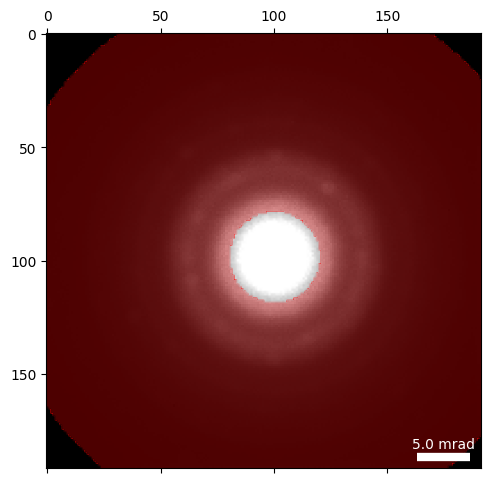

In [20]:
dataset.position_detector(
    mode = 'annular',
    geometry = (
        (0,0),
        (adf_radii[0],adf_radii[1]),
    ),
    centered = True
)

In [21]:
probe_array = dataset.data[30:32,30:32].mean((0,1)) 

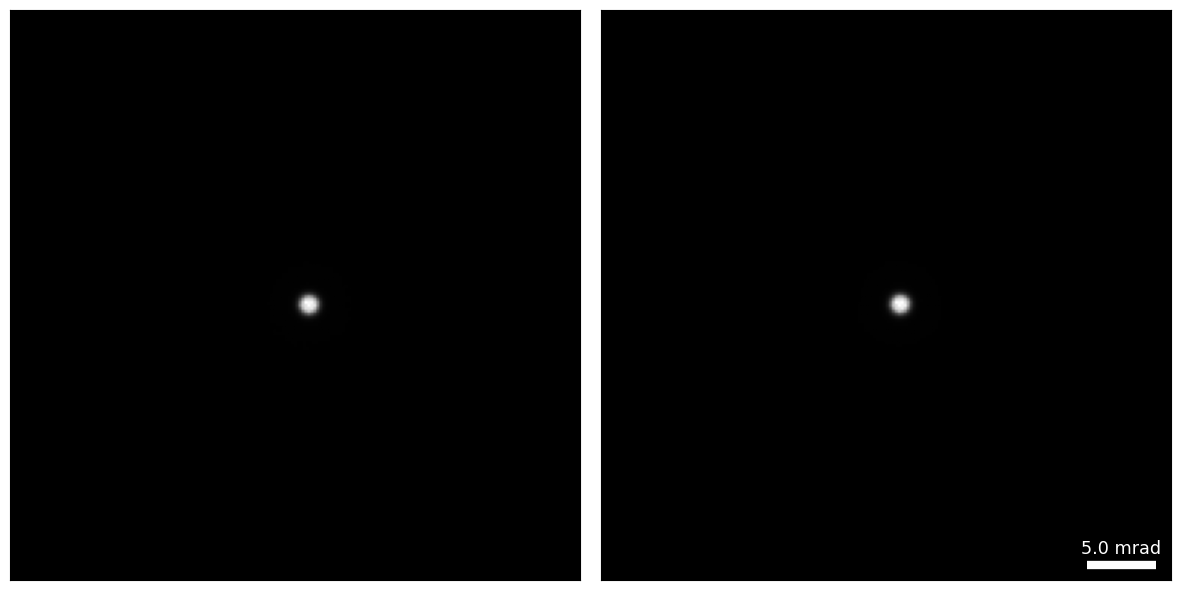

In [22]:
p4.show(
    [
        probe_array,
        dataset.tree('dp_mean'),
    ],
    vmax = 1,
    ticks = False,
)

100%|██████████| 3/3 [00:00<00:00, 485.68it/s]


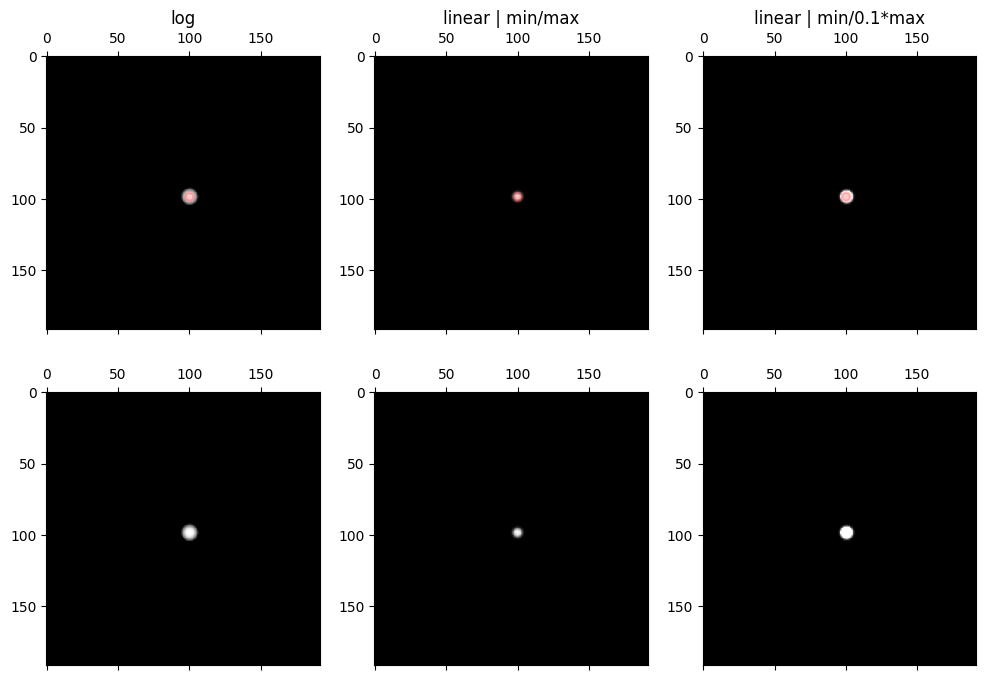

In [23]:
probe_align = dataset.get_vacuum_probe(
    align = True,
    # ROI = (0,2,0,25)
    ROI = (30,32,30,32)
);


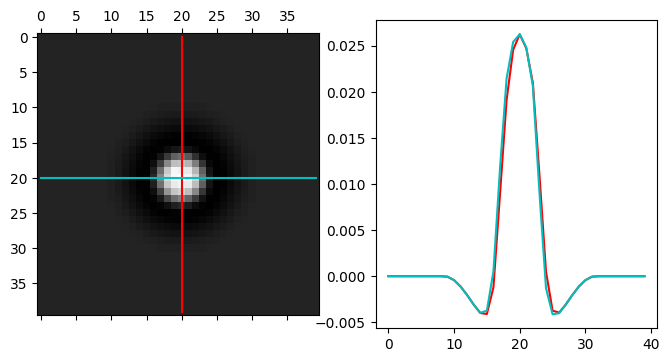

In [24]:
probe_kernel = probe_align.get_kernel(
    mode = 'sigmoid',
    radii = (probe_semiangle_px * 1.0, probe_semiangle_px * 4.0),
    bilinear=True,
)

# Plot the probe kernel
p4.visualize.show_kernel(
    probe_align.kernel, 
    R=20, 
    L=20, 
    W=1,
    figsize = (8,4),
)

# Creating Masks
To calculate similarity, you need two masks. 
One is the q_space_mask, which is an annular mask that is applied for the diffraction space.
The next one is the r_space_mask, which is another mask that is created by thresholding to remove the background(i.e. vacuum area) in the real space.
Even without the r_space_mask, you can create the similarity array (cluster.similarity_raw) but it is stronlgy recommended to apply the mask

In [25]:

def create_annular_mask(qx, qy, center, r1, r2):
    # Create a grid of coordinates
    x = np.arange(qx)
    y = np.arange(qy)
    x, y = np.meshgrid(x, y)
    
    # Calculate distances from the center
    distances = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    
    # Create the mask
    mask = (distances >= r1) & (distances <= r2)
    
    #returns: Boolean mask where True indicates pixels within the annular region.
    return mask

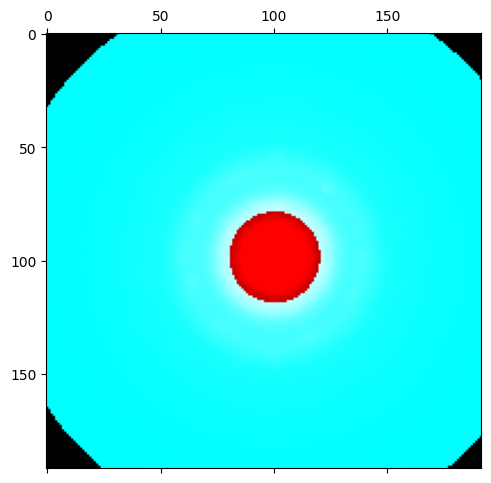

In [26]:
q_space_mask = create_annular_mask(dataset.shape[2],dataset.shape[3], (probe_qy0,probe_qx0), adf_radii[0], adf_radii[1])

p4.show(
    [
        dataset.tree("dp_mean"),
        q_space_mask, 
    ],
    ticks = True,
    combine_images = True,
    # power = 0.5,
    # vmax = 0.99,
)

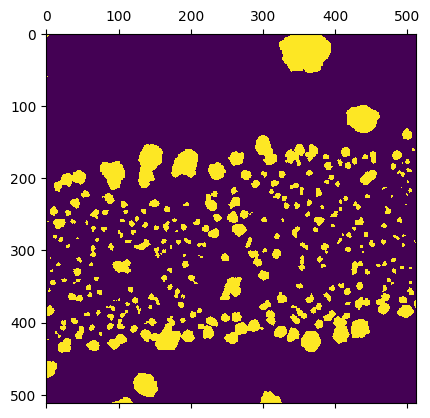

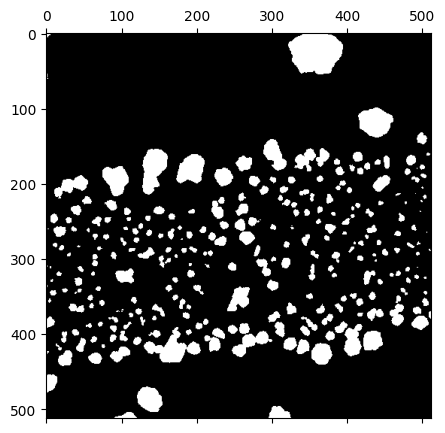

In [ ]:
fig_df= dataset.data.mean(axis=(2,3))

thresh = threshold_triangle(fig_df)
r_space_mask = fig_df < thresh        

fig, ax = p4.show(
    r_space_mask,
    returnfig = True,
)


# Creating Cluster

In [29]:
cluster = Cluster(
    dataset, 
    r_space_mask = r_space_mask)

In [30]:
cluster.find_similarity(
    q_space_mask=q_space_mask, 
    smooth_sigma=0)

  2%|▏         | 5715/262144 [00:03<02:53, 1478.13it/s]

100%|██████████| 262144/262144 [02:57<00:00, 1474.15it/s]


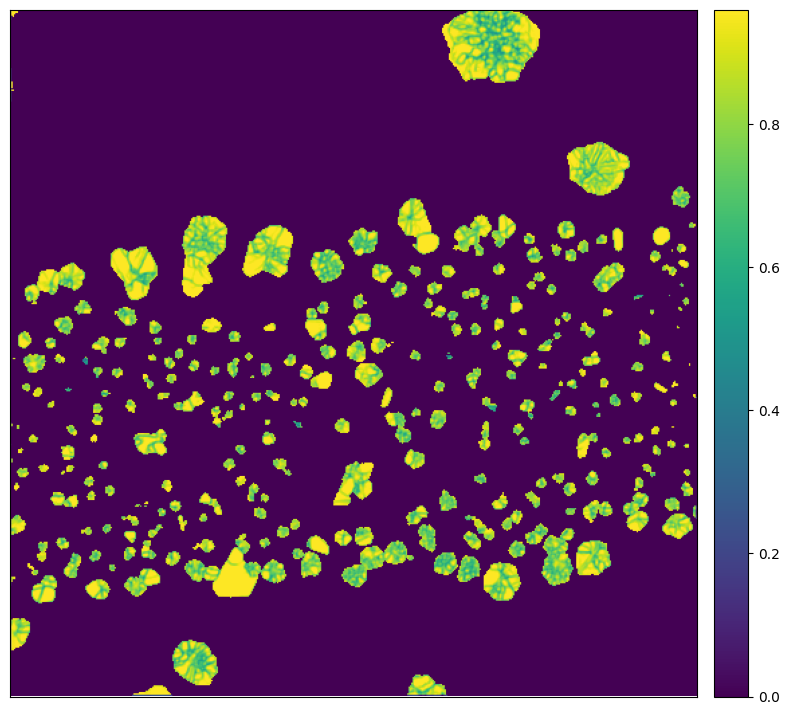

In [ ]:
p4.show(
    [
    np.mean(cluster.similarity, axis =2)
       
    ],
    cmap = 'viridis',
    ticks = False,
    show_cbar = True,
    figsize = (8,8)

)

In [ ]:
cluster.indexing_clusters_all(
    threshold = 0.9
)

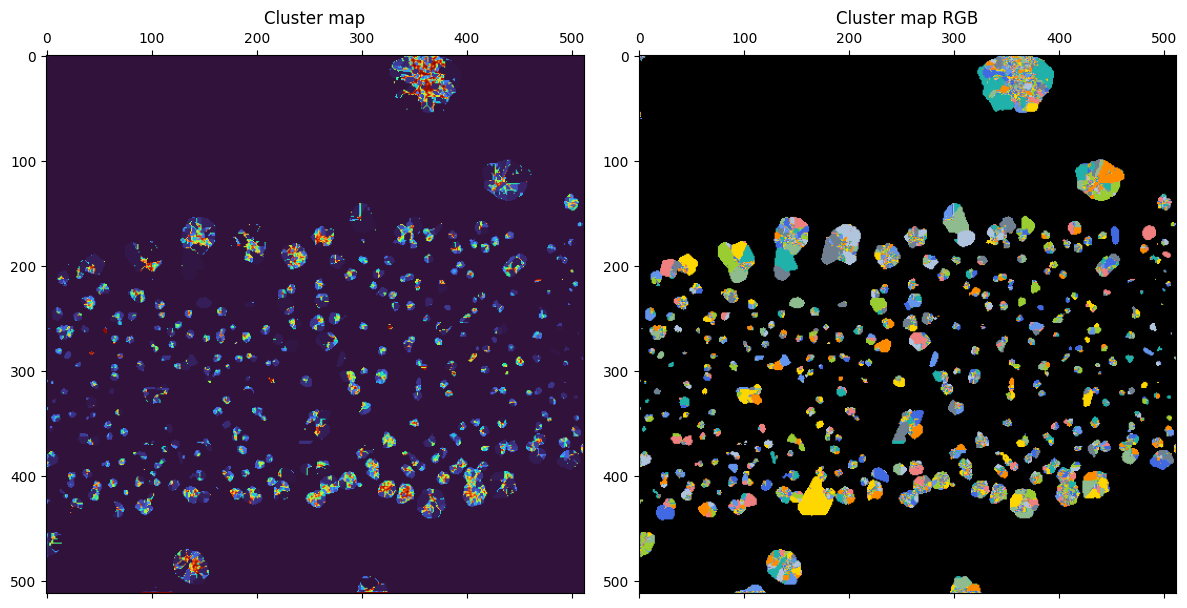

In [ ]:
fig, ax = p4.show(
    [cluster.cluster_map,
     cluster.cluster_map_rgb, 
    ],
    combine_images = False,
    returnfig = True,
    cmap= 'turbo',
    figsize= (8,8),
    ticks= True,
    borderwidth=0,
    vmax=0.3,
    title = ['Cluster map', 'Cluster map RGB'],   
)


# Creating Cluster DataCube

In [35]:
cluster.create_cluster_cube(
    min_cluster_size=1,
)

100%|██████████| 8644/8644 [00:00<00:00, 9021.45it/s] 


In [36]:
# Create a p4.DataCube object from the cluster_cube
cluster_datacube = p4.DataCube(
    data=cluster.cluster_cube,
)


In [39]:
cluster_datacube.get_dp_mean();

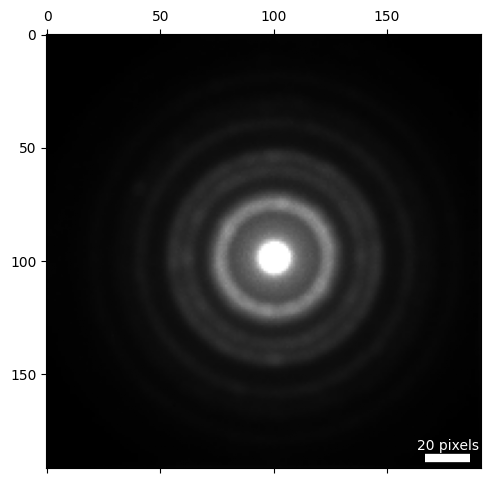

In [ ]:
p4.show(
    [
        cluster_datacube.tree('dp_mean'),   
    ],

    vmax = 0.996
)

# Checking the clustered DPs

In [ ]:
colors=['r','orange','yellow','lightgreen','lightseagreen','royalblue']

In [ ]:
cluster_interest = [83, 39, 42, 41, 221, 98]

rxs = []
rys= []

for i in cluster_interest:
    rxs.append(int(cluster.cluster_list[i][0][0]))
    rys.append(int(cluster.cluster_list[i][0][1]))

print(rxs)
print(rys)


[167, 414, 321, 396, 42, 194]
[418, 440, 103, 266, 372, 202]


(<Figure size 800x800 with 1 Axes>, <Axes: >)

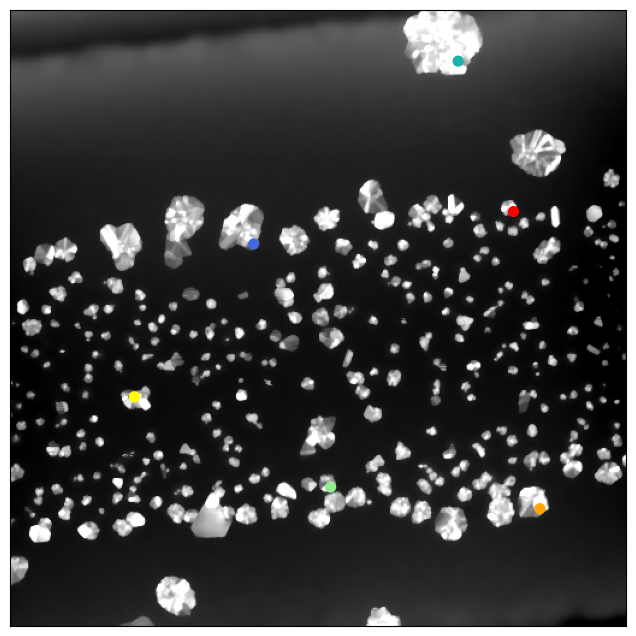

In [47]:
p4.visualize.show_points(
    dataset.tree('dark_field'),
    x=rxs,
    y=rys,
    pointcolor=colors,
    figsize=(8,8),
    returnfig = True,
    scalebar = False,
    ticks = False,
)

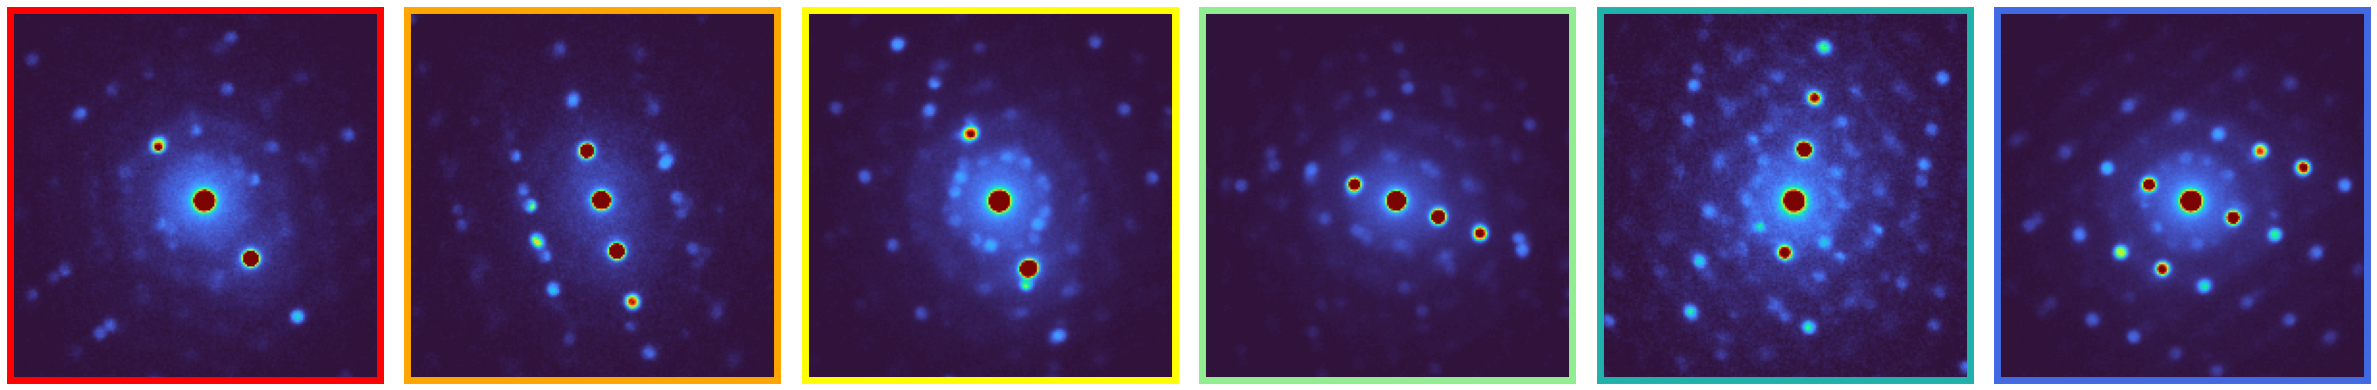

In [ ]:
blank = [0] * len(cluster_interest)
num_W = 6
num_H = int(len(cluster_interest)/num_W)

fig, ax = p4.visualize.show_image_grid(
    get_ar = lambda i:cluster_datacube.data[cluster_interest[i],blank[i],:,:], 
    H=num_H,
    W=num_W,
    axsize=(4,4),
    cmap= 'turbo',
    ticks = False,
    vmax = 0.996,
    returnfig= True,
    get_bordercolor = lambda i:colors[i],
)


# Disk Detection

In [60]:
blank = [0,0,0,0,0,0]
colors_dis= ['w','w','w','w','w','w']

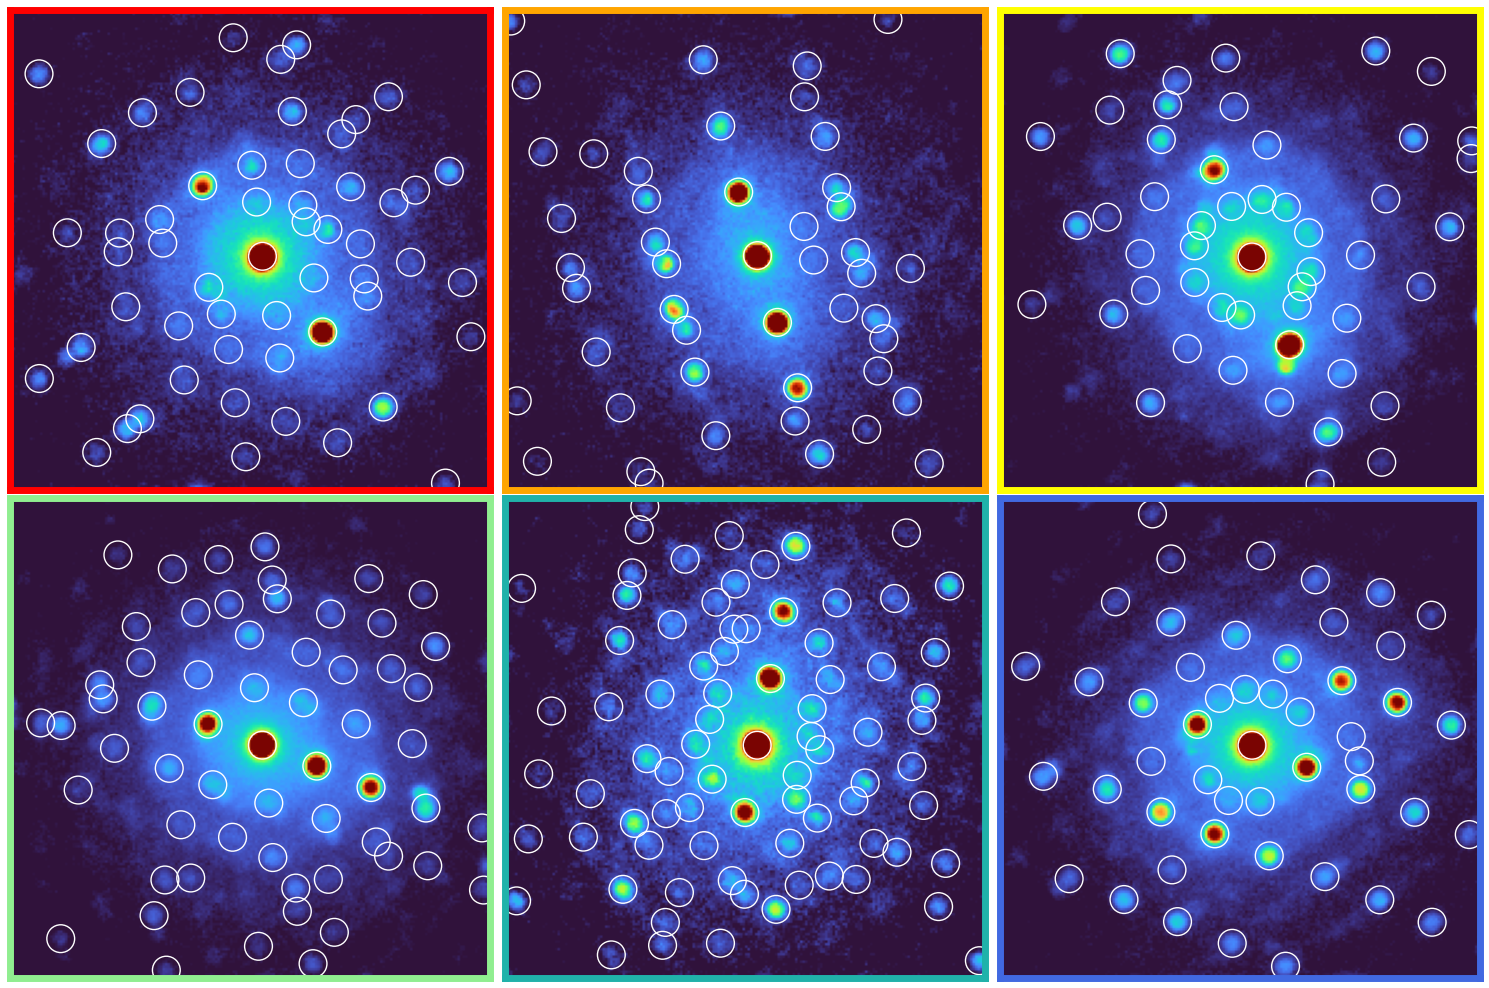

In [ ]:

# parameters
detect_params = {
    'corrPower': 1.0,
    'sigma': 0,
    'edgeBoundary': 2,
    'minRelativeIntensity': 0,
    'minAbsoluteIntensity': 5,
    'minPeakSpacing': 2,
    'subpixel' : 'poly',
    # 'subpixel' : 'multicorr',
    'upsample_factor': 8,
    'maxNumPeaks': 2000,
#     'CUDA': True,
}

disks_selected = cluster_datacube.find_Bragg_disks(
    data = (cluster_interest, blank),
    template = probe_kernel,
    **detect_params,
)

fig, ax = p4.visualize.show_image_grid(
    get_ar = lambda i:cluster_datacube.data[cluster_interest[i],blank[i],:,:],
    H=2, 
    W=3,
    axsize=(5,5),
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors_dis[i],
    open_circles = True,
    scale = 400,
    vmin = 0.3,
    vmax = 0.996,
    cmap = 'turbo',
    power = 0.5,
    returnfig= True,
)


In [62]:
# Find all Bragg peaks
# Note that here we have used "poly" disk detection, which is much faster, but less accurate.
# We do not need extremely precise peak locations to perform an ACOM analysis.

bragg_peaks = cluster_datacube.find_Bragg_disks(
    template = probe_kernel,
    **detect_params,
)

Finding Bragg Disks: 100%|██████████| 8.64k/8.64k [00:25<00:00, 342DP/s]


In [ ]:
# Save Bragg disk positions

# p4.save(
#     braggdisks/f'braggdisks_cluster.h5',
#     bragg_peaks,
#     mode='o',
# )

100%|██████████| 8644/8644 [00:00<00:00, 11082.52it/s]


# Bragg Disk Calibration

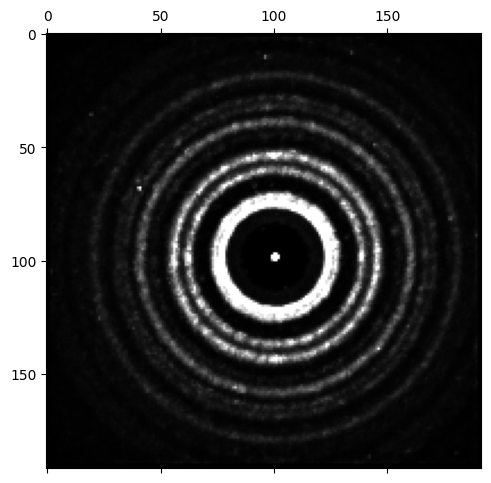

In [64]:
bvm_raw = bragg_peaks.get_bvm()

p4.show(
    bvm_raw, 
)

In [ ]:
qxy_origins = bragg_peaks.measure_origin(
    # mode = 'no_beamstop',
    center_guess = (probe_qx0,probe_qy0),
    score_method = 'distance',
)

In [66]:
bragg_peaks.calibration.set_origin((qxy_origins[0],qxy_origins[1]))

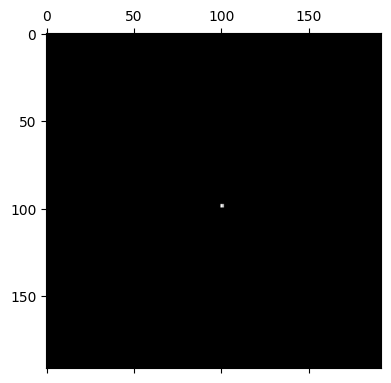

In [67]:
# Calculate BVM from centered data
bragg_vector_map_centered = bragg_peaks.get_bvm()

p4.show(
    bragg_vector_map_centered,
    figsize = (4,4),
    vmax = 1,
)

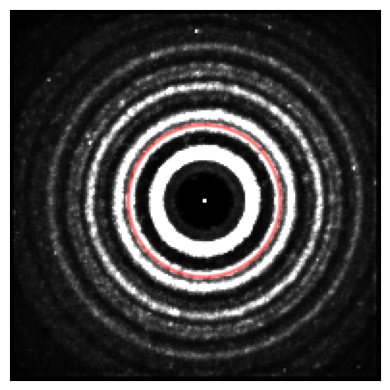

In [ ]:
# position integration
q_range = (39,40)

p4.show(
    bragg_vector_map_centered,
    annulus={
        'center':(probe_qx0,probe_qy0),
        'radii': q_range,
        'fill':True,
        'color':'r',
        'alpha':0.3
    },
    figsize = (4,4),
    ticks = False,

    intensity_range='absolute',
    vmin=0,
    vmax=3000
)

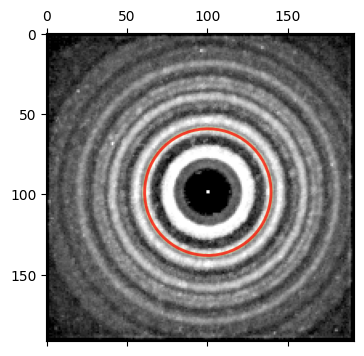

In [69]:
p_ellipse = bragg_peaks.fit_p_ellipse(
    bragg_vector_map_centered,
    center = (probe_qx0,probe_qy0),
    fitradii = q_range,
    figsize = (4,4),
    returncalc = True,
)

In [70]:
# apply the calibration
bragg_peaks.calibration.set_p_ellipse(p_ellipse)
print(np.round(p_ellipse,3))

[ 98.6   100.327  39.49   39.371  -0.516]


In [71]:
# The rotation of this dataset was determined independently (outside the scope of this notebook)
theta = 0
flip = False

In [ ]:
bragg_peaks.calibration.set_QR_rotflip((theta, flip))


# Pixel size calibration

In [ ]:
a_lat = 4.08
atom_num = 79
k_max = 2.4 


pos = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.5, 0.5],
    [0.5, 0.0, 0.5],
    [0.5, 0.5, 0.0],
])

# Make crystal
crystal = p4.process.diffraction.Crystal(
    pos, 
    atom_num, 
    (a_lat,a_lat,a_lat),
)
# Calculate structure factors
crystal.calculate_structure_factors(k_max)

In [74]:

pixel_size_inv_ang = 0.01811735 # From calibration file

bragg_peaks.calibration.set_Q_pixel_size(pixel_size_inv_ang)
bragg_peaks.calibration.set_Q_pixel_units('A^-1')

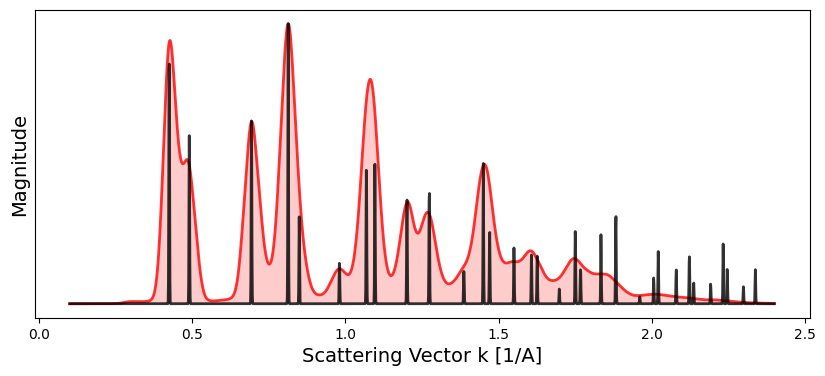

In [75]:
# Compare measured diffraction pattern with reference crystal structure
crystal.plot_scattering_intensity(
    bragg_peaks = bragg_peaks,
    # bragg_intensity_power  = 0.5,
    k_min = 0.1,
    
    k_broadening = 0.001,
        
    bragg_k_power = 1.0,
    bragg_k_broadening = 0.01,
)

Calibrated pixel size = 0.01814735 A^-1


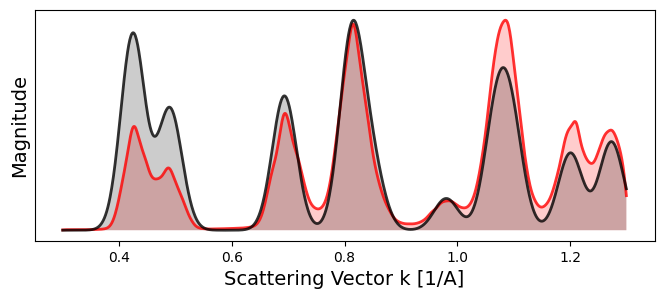

In [76]:
bragg_peaks_cali = crystal.calibrate_pixel_size(
    bragg_peaks = bragg_peaks,
    bragg_k_power = 2.0,
    k_min = 0.3,
    k_max = 1.3,
    k_step = 0.001,
    k_broadening = 0.002,
    plot_result = True,
    fit_all_intensities = False,
    figsize = (8,3),
)

# ACOM

In [78]:
# Define gold structure using manual input of the crystal structure again if needed
pos = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.5, 0.5],
    [0.5, 0.0, 0.5],
    [0.5, 0.5, 0.0],
])
atom_num = 79
a = 4.08
cell = a

crystal = p4.process.diffraction.Crystal(
    pos, 
    atom_num, 
    cell)

In [ ]:
# Calculate and plot gold structure factors
k_max = 2.0 

crystal.calculate_structure_factors(
    k_max,
)


In [80]:
# # Create an orientation plan for gold using pymatgen

crystal.orientation_plan(
    zone_axis_range = 'auto',
    angle_step_zone_axis = 0.5,
    angle_step_in_plane = 5.0,
    
    # angle_step_zone_axis = 1.0,
    # angle_coarse_zone_axis = 2.5,
    # angle_refine_range = 2.5,
    
    # angle_step_in_plane = 5.0,
    accel_voltage = energy,
#     CUDA = True,
#     intensity_power = 0.5,
#     intensity_power = 0.125,
#     radial_power = 2.0,
    # corr_kernel_size = 0.12,
    # tol_peak_delete = 0.08,
)

Automatically detected point group m-3m,
 using arguments: zone_axis_range = 
[[0 1 1]
 [1 1 1]], 
 fiber_axis=None, fiber_angles=None.


Orientation plan: 100%|██████████| 6105/6105 [00:00<00:00, 19362.23 zone axes/s]

Best fit lattice directions: z axis = ([0.488 0.495 0.719]), x axis = ([0.225 0.444 0.867]), with corr value = 10.101
Best fit lattice directions: z axis = ([0.006 0.249 0.969]), x axis = ([0.064 0.274 0.96 ]), with corr value = 9.229
Best fit lattice directions: z axis = ([0.147 0.689 0.71 ]), x axis = ([0.399 0.594 0.698]), with corr value = 12.765
Best fit lattice directions: z axis = ([0.109 0.654 0.749]), x axis = ([0.084 0.256 0.963]), with corr value = 11.171
Best fit lattice directions: z axis = ([0.025 0.274 0.961]), x axis = ([0.026 0.181 0.983]), with corr value = 10.682
Best fit lattice directions: z axis = ([0.404 0.454 0.794]), x axis = ([0.256 0.455 0.853]), with corr value = 14.742


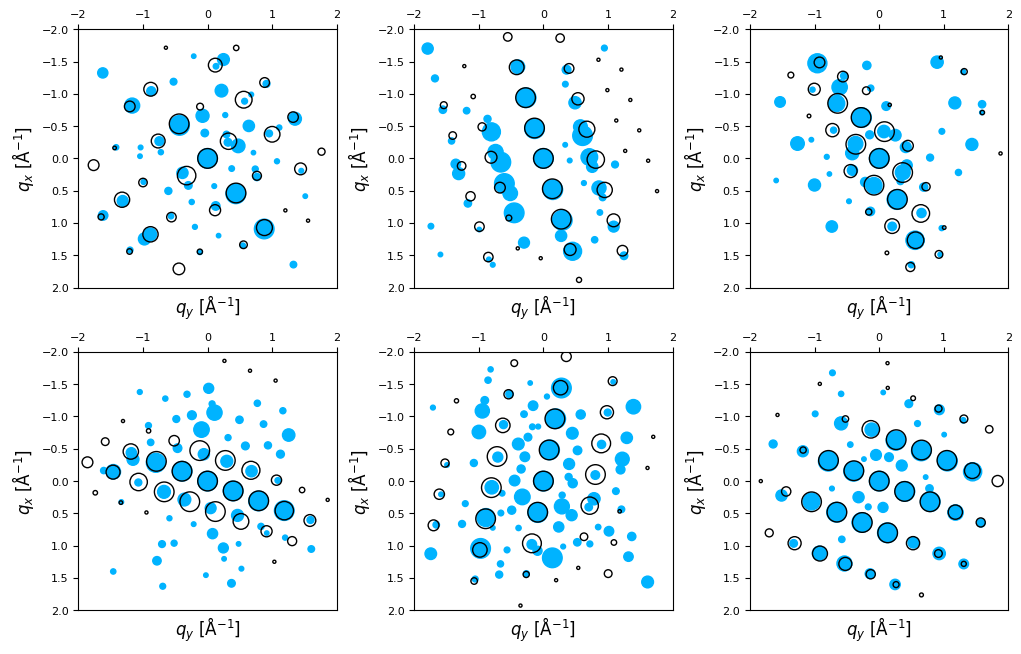

In [86]:
# Test matching on some probe positions
sigma_compare = 0.03  # Excitation error for the simulated diffraction patterns
figsize = (8,8)


xinds = cluster_interest
 
yind = 0

# plotting parameters
plot_params = {
    'scale_markers': 1e4,
    'scale_markers_compare': 2,
    'plot_range_kx_ky': crystal.k_max,
    'min_marker_size': 5,
    'max_marker_size': 200,
    'add_labels' : False,
    'marker':"o",
    'facecolor' : 'None',
    'edgecolor' : 'k',
    # 'show_axes': False,
    # 'figsize': (4,4),
    'returnfig' : True,
}

fig,ax = plt.subplots(2,3,figsize=(12,8))

for ind, xind in enumerate(xinds):
    # Find best fit orientations
    orientation  = crystal.match_single_pattern(
        bragg_peaks_cali.cal[xind,yind],
        num_matches_return = 1,
        verbose = True,
    )

    # Simulated bragg peaks from best fit orientations
    peaks_fit_0 = crystal.generate_diffraction_pattern(
        orientation,
        ind_orientation=0,
        sigma_excitation_error=sigma_compare)

    # plot orientation matching
    coords = np.unravel_index(ind, (2,3))
    p4.process.diffraction.plot_diffraction_pattern(
        peaks_fit_0,
        bragg_peaks_compare=bragg_peaks_cali.cal[xind,yind],
        input_fig_handle=(fig,[ax[coords[0],coords[1]]]),
        **plot_params,
       
    )

for i in range(2):
    for j in range(3):
        ax[i, j].set_xlabel(r"$q_y$ [Å$^{-1}$]", fontsize=12)
        ax[i, j].set_ylabel(r"$q_x$ [Å$^{-1}$]", fontsize=12)
        ax[i, j].tick_params(labelsize=8)

fig.subplots_adjust(wspace=0.3, hspace=0.1)

# fig.savefig(outdir/'AuNR_ts_10_cluster_ACOM_other_set_1.PNG')

# Orientation Mapping

In [87]:
# Fit orientation to all probe positions
orientation_map = crystal.match_orientations(
    bragg_peaks_cali,
    num_matches_return = 1,
    min_number_peaks = 3,
)

Matching Orientations:   0%|          | 0/8644 [00:00<?, ? PointList/s]

Matching Orientations: 100%|██████████| 8644/8644 [27:25<00:00,  5.25 PointList/s]


In [88]:
map_size = (dataset.shape[0],dataset.shape[1])
print(map_size)

(512, 512)


In [89]:
# Mapping cluster orientation to the whole map
from py4DSTEM.process.diffraction.utils import OrientationMap
new_map_ori = OrientationMap(num_x=512, num_y=512, num_matches=1)

default_orientation = 0

for cluster_idx, cluster_indices in enumerate(cluster.filtered_cluster_list):
    
    cluster_orientation = orientation_map.get_orientation(cluster_idx,0)  
    for x, y in cluster_indices:
        new_map_ori.set_orientation(cluster_orientation,x,y)

In [90]:
new_map_ori

OrientationMap(num_x=512, num_y=512, num_matches=1)

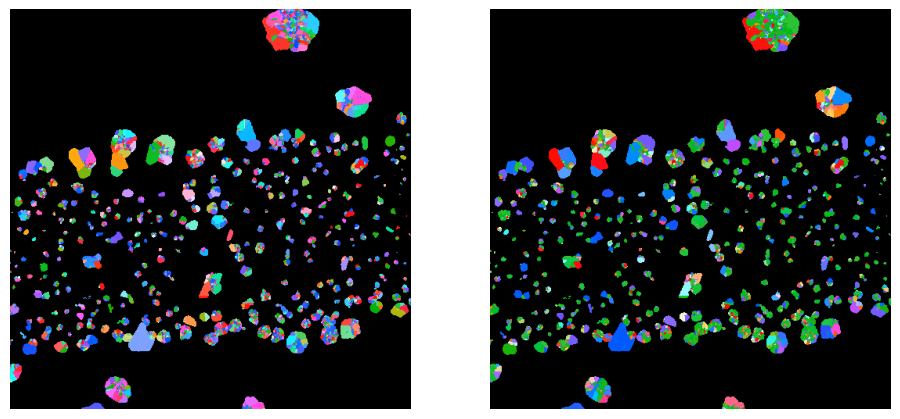

In [ ]:
# plot orientation map
images_orientation,fig,ax = images_orientation = crystal.plot_orientation_maps(
    new_map_ori,
    orientation_ind=0,
    corr_range = np.array([1,2]),
    camera_dist = 10,
    show_axes = False,
    show_legend = False,
    returnfig = True,
    figsize = (12,4)
    
)
# clear titles
ax[0].set_title("")
ax[1].set_title("")
ax[2].remove()  

# Strain Mapping 1) Bragg peaks of 'non-clustered' data

In [ ]:
dataset_nc = p4.DataCube(
    data=dataset
)

In [96]:
dataset_nc.calibration.set_Q_pixel_size(semiangle_convergence_mrad/probe_semiangle_px)
dataset_nc.calibration.set_Q_pixel_units('mrad')

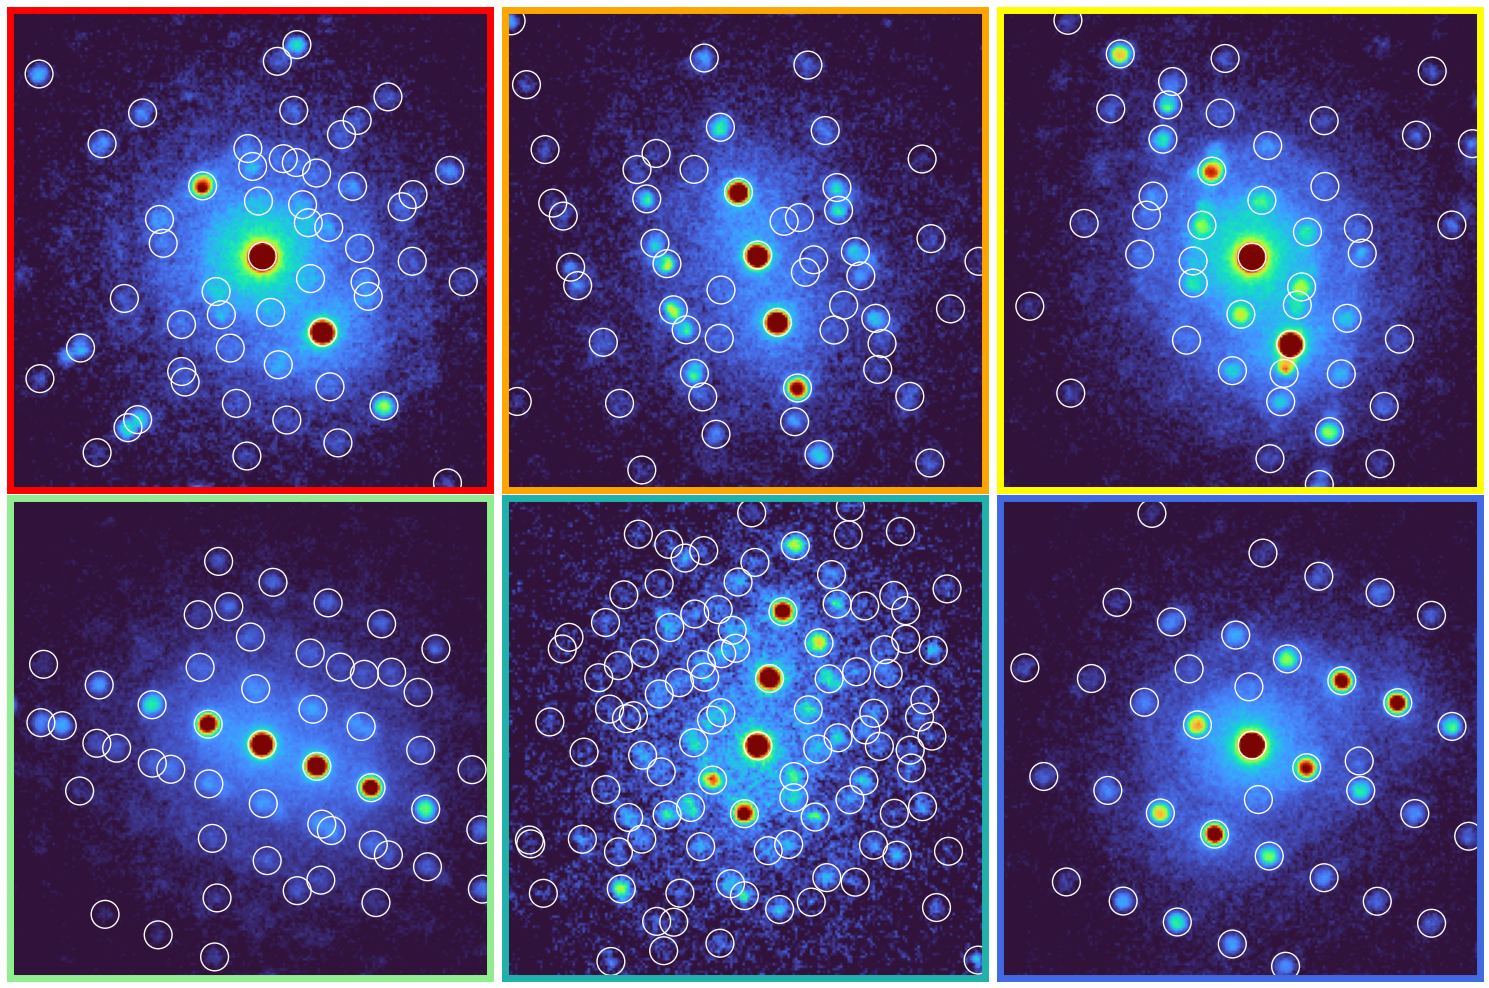

In [ ]:
# Disk detection for  non-clustered dataset

# parameters
detect_params_no_cluster = {
    'corrPower': 1.0,
    'sigma': 0,
    'edgeBoundary': 2,
    'minRelativeIntensity': 0,
    'minAbsoluteIntensity': 5.0,
    'minPeakSpacing': 2,
    'subpixel' : 'poly',
    # 'subpixel' : 'multicorr',
    'upsample_factor': 8,
    'maxNumPeaks': 2000,
#     'CUDA': True,
}

disks_selected_no_cluster = dataset_nc.find_Bragg_disks(
    data = (rxs, rys),
    template = probe_kernel,
    **detect_params_no_cluster,
)

fig, ax = p4.visualize.show_image_grid(
    get_ar = lambda i:dataset_nc.data[rxs[i],rys[i],:,:],
    H=2, 
    W=3,
    axsize=(5,5),
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected_no_cluster[i].data['qx'],
    get_y = lambda i: disks_selected_no_cluster[i].data['qy'],
    get_pointcolors = lambda i: colors_dis[i],
    open_circles = True,
    scale = 400,
    vmin = 0.3,
    vmax = 0.996,
    cmap = 'turbo',
    power = 0.5,
    returnfig= True,
)



In [98]:
bragg_peaks_no_cluster = dataset_nc.find_Bragg_disks(
    template = probe_kernel,
    **detect_params_no_cluster,
)

Finding Bragg Disks: 100%|██████████| 262k/262k [05:34<00:00, 783DP/s] 


In [ ]:
# # Save Bragg disk positions

# p4.save(
#     braggdisks/'braggdisks_no_cluster.h5',
#     bragg_peaks_no_cluster,
#     mode='o',
# )

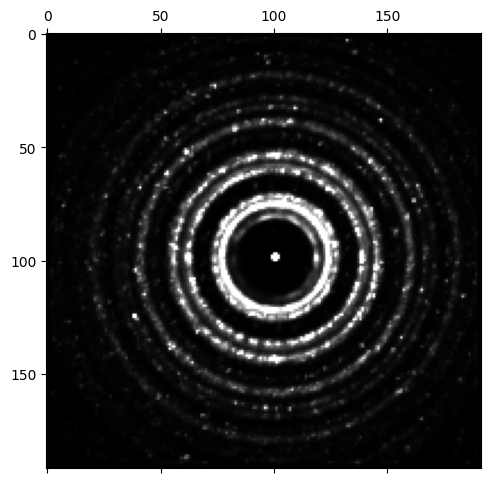

In [100]:
bvm_raw_no_cluster = bragg_peaks_no_cluster.get_bvm()

p4.show(
    bvm_raw_no_cluster, 
)

In [ ]:
qxy_origins_nc = bragg_peaks_no_cluster.measure_origin(
    # mode = 'no_beamstop',
    center_guess = (probe_qx0,probe_qy0),
    score_method = 'distance',
)

In [102]:
bragg_peaks_no_cluster.calibration.set_origin((qxy_origins_nc[0],qxy_origins_nc[1]))

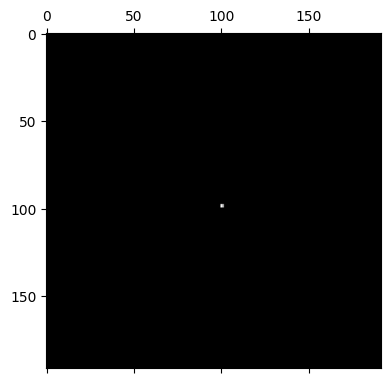

In [103]:
# Calculate BVM from centered data
bvm_no_cluster_centered = bragg_peaks_no_cluster.get_bvm()

p4.show(
    bvm_no_cluster_centered,
    figsize = (4,4),
    vmax = 1,
)

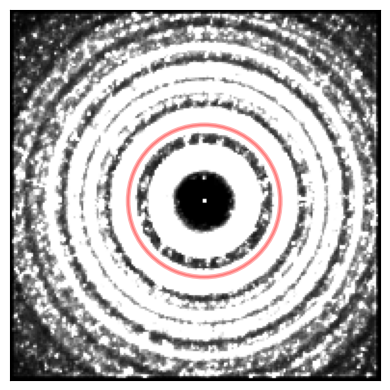

In [104]:
# position integration
# q_range = (31,35)
q_range = (39,40)

p4.show(
    bvm_no_cluster_centered,
    annulus={
        'center':(probe_qx0,probe_qy0),
        'radii': q_range,
        'fill':True,
        'color':'r',
        'alpha':0.3
    },
    figsize = (4,4),
    ticks = False,

    intensity_range='absolute',
    vmin=0,
    vmax=1200
)

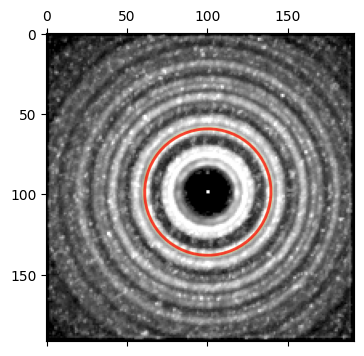

In [105]:
p_ellipse_no_cluster = bragg_peaks_no_cluster.fit_p_ellipse(
    bvm_no_cluster_centered,
    center = (probe_qx0,probe_qy0),
    fitradii = q_range,
    figsize = (4,4),
    returncalc = True,
)

In [106]:
# apply the calibration
bragg_peaks_no_cluster.calibration.set_p_ellipse(p_ellipse_no_cluster)
print(np.round(p_ellipse,3))

[ 98.6   100.327  39.49   39.371  -0.516]


In [ ]:
# The rotation of this dataset was determined independently (outside the scope of this notebook)
theta = 0
flip = False



In [ ]:
bragg_peaks_no_cluster.calibration.set_QR_rotflip((theta, flip))

In [108]:
bragg_peaks_no_cluster.calibration.set_Q_pixel_size(pixel_size_inv_ang)
bragg_peaks_no_cluster.calibration.set_Q_pixel_units('A^-1')

In [109]:
bragg_peaks_no_cluster.shape

(512, 512)

# Strain Map

In [110]:
crystal.orientation_kernel_size

array(0.08)

In [ ]:
strain_map = crystal.calculate_strain(
    bragg_peaks_no_cluster, 
    new_map_ori, 
    min_num_peaks = 5,
    rotation_range=np.pi*2, 
#     corr_kernel_size=0.02,
    intensity_weighting = True,
    corr_kernel_size = 0.04,
)

Calculating strains:   0%|          | 856/262144 [00:00<01:00, 4352.51 PointList/s]

Calculating strains: 100%|██████████| 262144/262144 [01:04<00:00, 4054.25 PointList/s]


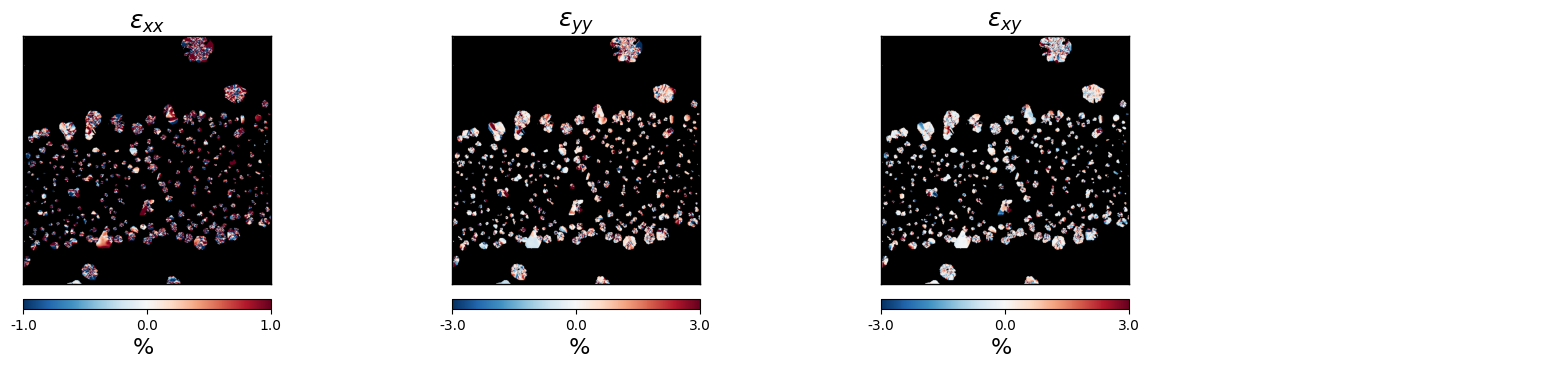

In [112]:
# plot the 4 components of the strain tensor
fig,ax = p4.visualize.show_strain(
    strain_map,
    vrange_exx=[-1.0, 1.0],
    vrange_theta=[0.0, 60.0],
    ticknumber=3,
    # axes_plots=(),
    # bkgrd=False,
    figsize=(15,5),
#     cmap='hsv',
    returnfig=True,
    cmap_theta = 'hsv',
    layout = 'horizontal',
    show_cbars=('exx','eyy','exy'),
)

ax_theta = ax[1][1]     # bottom-right = theta
ax_theta.remove()  